# Projet 5: notebook de tests

Ce notebook se compose de trois parties.

La première partie présente la mise en oeuvre d'une approche non supervisée afin de proposer des tags.

La deuxième partie présente les tests de différents algorithmes de classification supervisée sur des données en bag of words.

La troisième partie se compose également de tests de classification supervisée, mais cette fois-ci sur les données textuelles après avoir effectuée un word embedding.

In [1]:
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Importation des données

In [2]:
data = pd.read_csv("data.csv")
data

,Title,Body,Tags,title_bow_lem,body_bow_lem,title_bow_stem,body_bow_stem
0,spring mvc angularjs file upload org apa...,i have a java spring mvc web application as se...,"['mvc', 'spring', 'file', 'java']","['spring', 'mvc', 'angularjs', 'file', 'org', ...","['java', 'spring', 'mvc', 'application', 'serv...","['spring', 'mvc', 'angularj', 'file', 'org', '...","['java', 'spring', 'mvc', 'applic', 'server', ..."
1,what are some examples of design pattern imple...,i m a moderately skilled programmer using java...,"['javascript', 'design']","['design', 'javascript']","['programmer', 'javascript', 'guru', 'dom', 'm...","['design', 'javascript']","['programm', 'javascript', 'guru', 'dom', 'man..."
2,what s the best way to get to know linux or bs...,i d like to gain better knowledge of operating...,['linux'],"['linux', 'bsd']","['knowledge', 'operating', 'system', 'manageme...","['linux', 'bsd']","['knowledg', 'oper', 'system', 'manag', 'memor..."
3,is there a performance difference between i ...,is there a performance difference between and...,"['performance', 'c']","['performance', 'difference', 'c']","['performance', 'difference', 'value']","['perform', 'differ', 'c']","['perform', 'differ', 'valu']"
4,is there a performance difference between i ...,we have the question is there a performance di...,"['cplusplus', 'performance']","['performance', 'difference', 'cplusplus']","['performance', 'difference', 'c', 'answer', '...","['perform', 'differ', 'cplusplus']","['perform', 'differ', 'c', 'answer', 'cplusplus']"
...,...,...,...,...,...,...,...
24075,how does keras 1d convolution layer work with ...,i am currently developing a text classificatio...,['python'],"['convolution', 'layer', 'work', 'word', 'clas...","['text', 'classification', 'tool', 'validation...","['convolut', 'layer', 'work', 'word', 'classif...","['text', 'classif', 'tool', 'valid', 'accuraci..."
24076,clean architecture design pattern,i have some question about this pattern the...,"['design', 'java']","['architecture', 'design', 'pattern']","['pattern', 'database', 'layer', 'work', 'real...","['architectur', 'design', 'pattern']","['pattern', 'databas', 'layer', 'work', 'reali..."
24077,how to do nd distance and nearest neighbor cal...,this question is intended to be a canonical du...,"['arrays', 'python']","['distance', 'neighbor']","['duplicate', 'target', 'distance', 'shape', '...","['distanc', 'neighbor']","['duplic', 'target', 'distanc', 'shape', 'poin..."
24078,android studio emulator is not working on wind...,i have windows 11 on my system the system spe...,"['android', 'studio', 'windows']","['studio', 'emulator', 'whpx']","['system', 'system', 'specifiction', 'edition'...","['studio', 'emul', 'whpx']","['system', 'system', 'specifict', 'edit', 'hom..."


In [3]:
# Actuellement, ce que nous voyons entre crochets dans le tableau ne sont pas des listes mais des chaînes de caractères
# On les transforme en listes
for c in ['Tags', 'title_bow_lem', 'body_bow_lem', 'title_bow_stem', 'body_bow_stem']:
    data[c] = data[c].apply(lambda x: eval(x))

# Approche non supervisé: LDA

On va effectuer des classifications non supervisées à partir des différentes variables en bag of words et pour différents nombres de 'topics'. On comparera ces différentes classifications à l'aide du score de cohérence pour déterminer le meilleur choix. 

In [4]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test = train_test_split(data, train_size=0.8, random_state=27)

In [6]:
# Préprocessing des données pour LDA
def create_corpus(texts): 
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    return corpus, id2word

# Classification en k topics et calcul du score de cohérence
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = LdaMulticore(corpus=corpus,
                               id2word=dictionary,
                               num_topics=k, 
                               random_state=100,
                               chunksize=100,
                               passes=10)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

# Test de différents nombres de topics pour un même jeu de données
def test_multiple_topics(corpus, id2word):
    model_results = {'Topics': [],'Coherence': []}
    pbar = tqdm.tqdm(total=len(topics_range))

    for k in topics_range:
        cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
        model_results['Topics'].append(k)
        model_results['Coherence'].append(cv)

        pbar.update(1)
    resultats = pd.DataFrame(model_results)
    pbar.close()
    return resultats

In [7]:
# Les différents nombres de topics testés
min_topics = 15
max_topics = 50
step_size = 5
topics_range = range(min_topics, max_topics, step_size)

In [8]:
# Pour comparer les résultats suivant les différents jeu de données
compar_resultats = {}

## body_bow_lem

In [9]:
texts = X_train['body_bow_lem'].values.tolist()
corpus, id2word = create_corpus(texts)

In [10]:
resultats = test_multiple_topics(corpus, id2word)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:14<00:00, 36.35s/it]


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

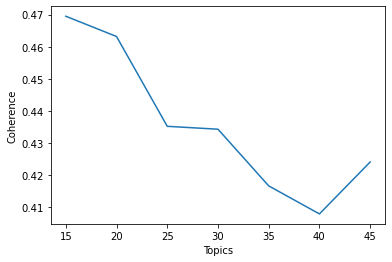

In [11]:
sns.lineplot(data=resultats, x="Topics", y="Coherence")

In [12]:
best_coherence_data_lem_body = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Coherence')
n_topics_optimal = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Topics')
n_topics_optimal

15

In [13]:
compar_resultats['body_bow_lem'] = [n_topics_optimal, resultats[['Coherence']].max().values[0]]

In [14]:
lda_model_lem_body = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics_optimal,
                                           random_state=100,
                                              chunksize=100,
                                           passes=10)

In [15]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lem_body, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\tony.mathieux\anaconda3\envs\projet_5_modelisation\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.115779  0.247745       1        1  10.271200
3      0.024240  0.231590       2        1   8.374311
13    -0.200503  0.137203       3        1   8.121297
0      0.045236  0.022476       4        1   7.858632
2      0.140804  0.169368       5        1   7.526945
8     -0.297700 -0.037341       6        1   7.526178
11     0.048590 -0.215521       7        1   7.260704
12     0.061272  0.087441       8        1   7.203059
9     -0.070278 -0.091868       9        1   6.618284
4     -0.095170  0.052395      10        1   6.143252
7      0.278428  0.042898      11        1   5.245681
5      0.261380 -0.123887      12        1   4.837174
10    -0.188756 -0.126821      13        1   4.783094
6      0.160522 -0.145134      14        1   4.618929
1     -0.052286 -0.250544      15        1   3.611261, topic_info=           Term         Freq        Total Category  logprob  loglift
185       image  2394.000000  2394.000000  Default  30.0000  30.0000
56   javascript  2518.000000  2518.000000  Default  29.0000  29.0000
704        view  2116.000000  2116.000000  Default  28.0000  28.0000
48         file  5493.000000  5493.000000  Default  27.0000  27.0000
265       array  1448.000000  1448.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
27       method    75.749254  3098.260747  Topic15  -5.2962  -0.3901
48         file    81.197560  5493.266054  Topic15  -5.2268  -0.8933
51      version    67.851824  1820.481974  Topic15  -5.4063   0.0316
325        page    68.846431  2214.792106  Topic15  -5.3918  -0.1499
217       model    58.389436  1102.405765  Topic15  -5.5565   0.3830

[1161 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3355      7  0.913740           aar
3355      8  0.067684           aar
6920      5  0.892177           acc
1635     15  0.958750  acceleration
301       1  0.460898        access
...     ...       ...           ...
1143      6  0.017372           zip
1143      7  0.008686           zip
1143     12  0.790443           zip
1143     13  0.043431           zip
6486      8  0.961883          zone

[5567 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 4, 14, 1, 3, 9, 12, 13, 10, 5, 8, 6, 11, 7, 2])

## title_bow_lem

In [16]:
texts = X_train['title_bow_lem'].values.tolist()
corpus, id2word = create_corpus(texts)

In [17]:
resultats = test_multiple_topics(corpus, id2word)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:37<00:00, 22.49s/it]


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

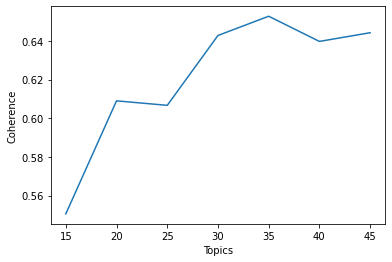

In [18]:
sns.lineplot(data=resultats, x="Topics", y="Coherence")

In [19]:
best_coherence_title_lem_body = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Coherence')
n_topics_optimal = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Topics')
n_topics_optimal

35

In [20]:
compar_resultats['title_bow_lem'] = [n_topics_optimal, resultats[['Coherence']].max().values[0]]

In [21]:
lda_model_lem_title = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics_optimal,
                                           random_state=100,
                                              chunksize=100,
                                           passes=10)

In [22]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lem_title, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\tony.mathieux\anaconda3\envs\projet_5_modelisation\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.451122 -0.116889       1        1  3.851598
27     0.018525  0.453321       2        1  3.638519
29     0.284573  0.247399       3        1  3.592683
5     -0.351080  0.324605       4        1  3.591146
15     0.145500  0.428898       5        1  3.393375
3     -0.241272  0.275203       6        1  3.339681
13    -0.461974  0.054130       7        1  3.214473
24    -0.397750  0.184378       8        1  3.136785
4      0.388847  0.132893       9        1  3.114864
0     -0.103015 -0.429914      10        1  3.101234
17     0.218201 -0.085947      11        1  3.051394
6      0.211694  0.340319      12        1  2.988441
33     0.375553  0.275982      13        1  2.943156
11    -0.432142 -0.157977      14        1  2.918444
12     0.260958 -0.356376      15        1  2.905272
22     0.026887 -0.454215      16        1  2.897054
1     -0.242175 -0.378017      17        1  2.814908
16     0.369594 -0.251857      18        1  2.807439
34    -0.088530  0.418028      19        1  2.796173
25     0.153630 -0.410487      20        1  2.771368
18    -0.276583  0.074251      21        1  2.737866
32     0.067208 -0.289262      22        1  2.732970
20     0.439947  0.032077      23        1  2.725179
2      0.022406  0.111554      24        1  2.717658
23     0.268901 -0.203515      25        1  2.653135
8     -0.087714 -0.155507      26        1  2.630297
28    -0.168465  0.363854      27        1  2.579301
26     0.275617  0.032932      28        1  2.546821
19    -0.272897 -0.161557      29        1  2.518222
14    -0.375841 -0.050024      30        1  2.463758
9     -0.123924  0.109800      31        1  2.296281
30    -0.131099 -0.281162      32        1  2.262431
10    -0.312048 -0.260570      33        1  2.230454
21     0.041709 -0.045710      34        1  2.224723
31     0.045637  0.229360      35        1  1.812898, topic_info=            Term        Freq       Total Category  logprob  loglift
8     javascript  705.000000  705.000000  Default  30.0000  30.0000
85          file  712.000000  712.000000  Default  29.0000  29.0000
28        python  759.000000  759.000000  Default  28.0000  28.0000
234            v  557.000000  557.000000  Default  27.0000  27.0000
46          java  633.000000  633.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
2490    exchange    8.715758    9.717868  Topic35  -4.8450   3.9014
1566   coroutine    8.215736    9.217846  Topic35  -4.9041   3.8952
254        touch    8.785906    9.862506  Topic35  -4.8370   3.8947
631    actionbar   17.162191   21.087279  Topic35  -4.1674   3.8043
960          bug   11.008738   14.541155  Topic35  -4.6114   3.7320

[1227 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1237     24  0.924881            aar
934      30  0.913392  accelerometer
126       1  0.089852         access
126      31  0.902422         access
2420     21  0.941191        account
...     ...       ...            ...
1470     22  0.943830        youtube
1167     27  0.918247              z
1948     22  0.907310           zend
1333     16  0.967077            zip
108      27  0.928737           zoom

[1450 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 28, 30, 6, 16, 4, 14, 25, 5, 1, 18, 7, 34, 12, 13, 23, 2, 17, 35, 26, 19, 33, 21, 3, 24, 9, 29, 27, 20, 15, 10, 31, 11, 22, 32])

## body_bow_stem

In [23]:
texts = X_train['body_bow_stem'].values.tolist()
corpus, id2word = create_corpus(texts)

In [24]:
resultats = test_multiple_topics(corpus, id2word)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:02<00:00, 34.59s/it]


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

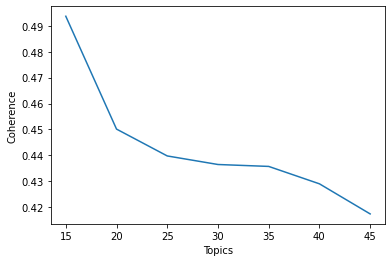

In [25]:
sns.lineplot(data=resultats, x="Topics", y="Coherence")

In [26]:
n_topics_optimal = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Topics')
n_topics_optimal

15

In [27]:
compar_resultats['body_bow_stem'] = [n_topics_optimal, resultats[['Coherence']].max().values[0]]

In [28]:
lda_model_stem_body = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics_optimal,
                                           random_state=100,
                                              chunksize=100,
                                           passes=10)

In [29]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_stem_body, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\tony.mathieux\anaconda3\envs\projet_5_modelisation\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.235347  0.130216       1        1  11.567956
0     -0.184772  0.041692       2        1  10.285865
4     -0.134622 -0.214229       3        1  10.097830
6     -0.017825 -0.255223       4        1   7.905162
8      0.117068 -0.227558       5        1   7.444386
11    -0.057775 -0.091437       6        1   7.044701
3      0.080500  0.303141       7        1   6.784484
14    -0.215328 -0.110275       8        1   6.490722
1      0.026663  0.088124       9        1   5.293680
12    -0.087176  0.153681      10        1   4.909992
13     0.001062  0.179299      11        1   4.881211
9      0.073284 -0.014535      12        1   4.707188
7      0.153644 -0.120035      13        1   4.474428
5      0.299249  0.022521      14        1   4.464905
2      0.181378  0.114618      15        1   3.647491, topic_info=        Term         Freq        Total Category  logprob  loglift
183     imag  2508.000000  2508.000000  Default  30.0000  30.0000
686     view  1983.000000  1983.000000  Default  29.0000  29.0000
321     page  2310.000000  2310.000000  Default  28.0000  28.0000
48      file  5300.000000  5300.000000  Default  27.0000  27.0000
169      app  3677.000000  3677.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
376  process    77.999249  1291.936550  Topic15  -5.2768   0.5039
9       case    66.375032  1836.501912  Topic15  -5.4382  -0.0092
139     edit    64.693044  1225.518923  Topic15  -5.4639   0.3697
133   answer    63.640309  1323.166175  Topic15  -5.4803   0.2766
107    class    64.093036  2982.710724  Topic15  -5.4732  -0.5291

[1171 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2722     13  0.856824     abcd
1551      6  0.930977  acceler
1551     12  0.023871  acceler
297       1  0.402742   access
297       2  0.148409   access
...     ...       ...      ...
1049      6  0.902753   youtub
1049      9  0.034282   youtub
1049     10  0.011427   youtub
4617     12  0.915452     yyyi
1477     13  0.916559    zombi

[5759 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 1, 5, 7, 9, 12, 4, 15, 2, 13, 14, 10, 8, 6, 3])

## title_bow_stem

In [30]:
texts = X_train['title_bow_stem'].values.tolist()
corpus, id2word = create_corpus(texts)

In [31]:
resultats = test_multiple_topics(corpus, id2word)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:33<00:00, 21.86s/it]


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

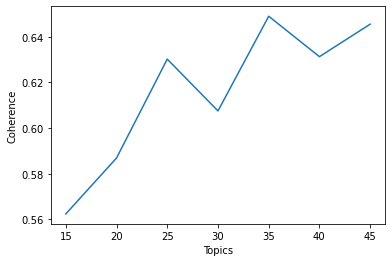

In [32]:
sns.lineplot(data=resultats, x="Topics", y="Coherence")

In [33]:
best_coherence_title_lem_body = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Coherence')
n_topics_optimal = resultats._get_value(resultats[['Coherence']].idxmax().values[0], 'Topics')
n_topics_optimal

35

In [34]:
compar_resultats['title_bow_stem'] = [n_topics_optimal, resultats[['Coherence']].max().values[0]]

In [35]:
lda_model_stem_title = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics_optimal,
                                           random_state=100,
                                              chunksize=100,
                                           passes=10)

In [36]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_stem_title, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\tony.mathieux\anaconda3\envs\projet_5_modelisation\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
21     0.462688 -0.124608       1        1  3.908763
34     0.026010  0.414636       2        1  3.638368
4      0.315078  0.315701       3        1  3.549872
11    -0.340165  0.343569       4        1  3.540570
25     0.138842  0.462147       5        1  3.486073
32    -0.272379  0.279613       6        1  3.433807
3     -0.473303  0.026996       7        1  3.400959
27    -0.428451  0.177749       8        1  3.376290
28     0.431980  0.128867       9        1  3.333835
29    -0.116286 -0.448320      10        1  3.304392
6      0.299061 -0.089695      11        1  3.233160
24     0.205004  0.346626      12        1  3.104085
16     0.380735  0.234284      13        1  3.072053
31    -0.442432 -0.176069      14        1  3.004190
12     0.266740 -0.366390      15        1  2.962776
30     0.018509 -0.449852      16        1  2.960053
18    -0.272399 -0.380427      17        1  2.844807
8      0.361004 -0.252411      18        1  2.823561
22    -0.105189  0.434156      19        1  2.818247
0      0.149173 -0.421343      20        1  2.813403
26    -0.295011  0.082580      21        1  2.809738
9      0.062784 -0.287174      22        1  2.717708
1      0.411098  0.003487      23        1  2.658769
14     0.016834  0.120930      24        1  2.531572
17     0.218506 -0.213419      25        1  2.483417
7     -0.068743 -0.144644      26        1  2.451471
10    -0.152161  0.337565      27        1  2.449755
13     0.233915  0.071471      28        1  2.425785
2     -0.225786 -0.126302      29        1  2.230206
33    -0.349115 -0.059093      30        1  2.210058
20    -0.137923  0.115442      31        1  2.178675
5     -0.137107 -0.297360      32        1  2.170171
19    -0.298332 -0.242377      33        1  2.106868
15     0.052712 -0.040640      34        1  1.983759
23     0.064111  0.224301      35        1  1.982785, topic_info=            Term        Freq       Total Category  logprob  loglift
28        python  760.000000  760.000000  Default  30.0000  30.0000
85          file  701.000000  701.000000  Default  29.0000  29.0000
8     javascript  671.000000  671.000000  Default  28.0000  28.0000
46          java  625.000000  625.000000  Default  27.0000  27.0000
233           vs  569.000000  569.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
389        mocha   10.316885   11.323208  Topic35  -4.7659   3.8276
25         decor    8.700527    9.706850  Topic35  -4.9363   3.8112
72         layer   34.228453   44.372859  Topic35  -3.5666   3.6611
47        restor   10.708411   12.466089  Topic35  -4.7287   3.7687
1308    procedur   11.833551   16.798417  Topic35  -4.6287   3.5703

[1229 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
904       4  0.960599  acceleromet
126       2  0.270062       access
126      26  0.718841       access
1635     15  0.899500      account
2217     12  0.889941     accuraci
...     ...       ...          ...
2499      3  0.872382         yyyi
1127     21  0.975386            z
1857      5  0.825731         zend
1280     11  0.965509          zip
108      29  0.933240         zoom

[1445 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 35, 5, 12, 26, 33, 4, 28, 29, 30, 7, 25, 17, 32, 13, 31, 19, 9, 23, 1, 27, 10, 2, 15, 18, 8, 11, 14, 3, 34, 21, 6, 20, 16, 24])

## Bilan de la LDA

In [37]:
pd.DataFrame(compar_resultats, index=['n_topics', 'coherence_score'])

,body_bow_lem,title_bow_lem,body_bow_stem,title_bow_stem
n_topics,15.000000,35.000000,15.000000,35.000000
coherence_score,0.469498,0.652726,0.493682,0.648948


Il y a peu d'écart entre la lemmatisation et la stemmatisation. En revanche le fait de ne prendre en compte que les titres donne clairement de meilleurs résultats.

In [38]:
texts = X_train['title_bow_lem'].values.tolist()
corpus, id2word = create_corpus(texts)

In [40]:
M_topics_words = pd.DataFrame(
    lda_model_lem_title.get_topics(), 
    columns=lda_model_lem_title.id2word.values(), 
    index=[f'topic {i}' for i in range(lda_model_lem_title.num_topics)])

In [41]:
M_topics_words

,asm,name,q0,register,locationlistener,network_provider,ssl,change,javascript,orientation,...,actionfilter,areaname,controllername,pyvenv,venv,print_r,fileinputstream,prophet,inject,diameter
topic 0,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000250,0.000015,...,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015
topic 1,0.000017,0.000133,0.000017,0.000017,0.000017,0.000017,0.000022,0.000409,0.406708,0.000133,...,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017
topic 2,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000030,0.000018,...,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018
topic 3,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000019,0.000014,...,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014
topic 4,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000020,0.000015,...,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015
topic 5,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,...,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013
topic 6,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000063,0.000016,...,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016
topic 7,0.000012,0.000013,0.000012,0.000012,0.000012,0.000012,0.000012,0.000123,0.000097,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
topic 8,0.000019,0.000019,0.000019,0.000022,0.000019,0.000019,0.000023,0.000019,0.000061,0.000019,...,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019
topic 9,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000104,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022


In [42]:
a = len(lda_model_lem_title.get_document_topics(corpus[0], minimum_probability=0))
M_quest_topics = {i:[lda_model_lem_title.get_document_topics(corpus[i], minimum_probability=0)[j][1] for j in range(a)] for i in range(len(corpus))}
M_quest_topics = pd.DataFrame.from_dict(M_quest_topics, orient='index')
M_quest_topics

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.005716,0.005716,0.005716,0.005716,0.005716,0.005716,0.005716,0.005716,0.005716,0.005716,...,0.005716,0.005716,0.605571,0.005716,0.005716,0.005716,0.005716,0.005716,0.005716,0.005716
1,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,...,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571
2,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,...,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286
3,0.007143,0.258059,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,...,0.007143,0.007143,0.007143,0.007143,0.256294,0.007143,0.007143,0.007143,0.007143,0.007143
4,0.004082,0.146938,0.004082,0.004082,0.004082,0.004082,0.146938,0.004082,0.004082,0.004082,...,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.432684,0.004082,0.004082,0.004082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19259,0.004082,0.146936,0.004082,0.146942,0.004082,0.004082,0.146938,0.004082,0.004082,0.146937,...,0.004082,0.004082,0.004082,0.004082,0.146882,0.146995,0.004082,0.004082,0.004082,0.004082
19260,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,...,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143
19261,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.146941,0.004082,0.004082,...,0.004082,0.004082,0.004082,0.004082,0.434406,0.004082,0.146991,0.004082,0.145129,0.004082
19262,0.007143,0.257131,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,...,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.257145,0.007143


In [43]:
M_quest_words = np.dot(M_quest_topics.to_numpy(), M_topics_words.to_numpy())
M_quest_words

array([[1.2911474e-03, 1.9081296e-02, 2.0611663e-04, ..., 1.4978060e-05,
        1.4978060e-05, 1.4978060e-05],
       [7.7619559e-05, 2.7030976e-03, 2.6426729e-05, ..., 1.7408620e-05,
        1.7408620e-05, 1.7408620e-05],
       [4.7110952e-05, 1.3666647e-03, 2.1514381e-05, ..., 1.7005301e-05,
        1.7005301e-05, 1.7005301e-05],
       ...,
       [2.4529892e-05, 4.1328341e-04, 1.7216473e-05, ..., 1.5928144e-05,
        1.5928144e-05, 1.5928144e-05],
       [3.2003176e-05, 2.3876028e-02, 1.9204668e-05, ..., 1.6950089e-05,
        1.6950089e-05, 1.6950089e-05],
       [3.3528344e-05, 6.8991893e-04, 2.0729731e-05, ..., 1.8475130e-05,
        1.8475130e-05, 1.8475130e-05]], dtype=float32)

In [44]:
M_quest_words.shape

(19264, 7080)

# Appoche supervisée: bag of words

On commence par mettre les classes, c'est-à-dire la colonne 'Tags', sous un format approprié.

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

In [5]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(data['Tags'])
y = pd.DataFrame(y, columns=multilabel.classes_)
y

,algorithm,android,api,arrays,aspdotnet,c,cocoa,core,cplusplus,csharp,...,sql,string,studio,swift,testing,touch,visual,web,windows,xcode
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24077,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24078,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


On peut effectuer énormément de tests différents. En effet, on dispose de 4 variables différentes pour effectuer des tests ('title_bow_lem', 'body_bow_lem', 'title_bow_stem' et 'body_bow_stem') et de toutes une panoplie d'algorithmes de classification supervisé, lesquels fonctionnant avec des hyperparamètres que l'on peut modifier. Tout cela fait beaucoup trop de possibilités.

Mais on peut raisonnablement penser que le passage d'une version des données lemmatisées à son homologue stemmatisées ne va pas modifier considérablement les performances d'un algorithme. De plus on aimerai bien qu'il n'y ai pas un trop gros écart de performance entre un entrainement sur les titres et un entraînement sur le corps des questions puisque cela signifierait que l'algorithme est très sensible à la longueur des questions, ce que l'on ne controle pas.

On va donc effectuer un premier tri des algorithmes à l'aide d'un seul jeu de données: 'body_bow_lem'. De plus les temps de calcul risquent d'être assez long donc on fera des validations croisées seulement après avoir éliminé les algorithmes inefficaces.

In [6]:
from sklearn.model_selection import train_test_split

In [13]:
X = data['body_bow_lem'].apply(lambda x: ' '.join(x))
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=21, train_size=0.7)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Les différents algorithme que nous allons tester
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Il s'agit d'une classification multilabel
from sklearn.multiclass import OneVsRestClassifier

# Pour mesurer la qualité des prédictions
from sklearn.metrics import jaccard_score

# Pour la validation croisée
from sklearn.model_selection import GridSearchCV

# Pour mesurer les temps de calcul
import timeit

In [22]:
resultats = {}

In [16]:
def test_model(model, X, Y):
    pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(model)),
            ])
    start_time = timeit.default_timer()
    pipeline.fit(X, Y)
    temps = timeit.default_timer() - start_time
    print("Temps d'entrainement: {}".format(temps))
    return pipeline

## Multinomial

In [17]:
NB_pipeline = test_model(MultinomialNB(), X_train, Y_train)

Temps d'entrainement: 0.32881629999999973


In [18]:
pred = NB_pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.00512526865843316

Le modèle est rapide à entrainer, mais le résultat est catastrophique.

## Linear SVC

In [19]:
SVC_pipeline = test_model(LinearSVC(), X_train, Y_train)

Temps d'entrainement: 1.1060549999999978


In [20]:
pred = SVC_pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.3069903028439561

Ce n'est pas bon, mais on a au moins un résultat non nul. Le temps d'entraînement est très correct. On peut oublier le modèle précédent.

In [23]:
del NB_pipeline

NameError: name 'NB_pipeline' is not defined

In [24]:
resultats['SVC_body_lem'] = jaccard_score(Y_test, pred, average='macro')

## Forêts aléatoires

L'entrainement de ce modèle est extrêmement long, même avec un hyperparamètre n_estimators assez faible et sans validation croisée, donc on ne l'utilisera pas.

In [25]:
RFC_pipeline = test_model(RandomForestClassifier(n_estimators=50), X_train, Y_train)

Temps d'entrainement: 87.94872220000002


In [26]:
pred = RFC_pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.1625002902394969

In [27]:
del RFC_pipeline

## AdaBoost

In [28]:
ADB_pipeline = test_model(AdaBoostClassifier(n_estimators=100, learning_rate=1), X_train, Y_train)

Temps d'entrainement: 86.96763369999996


In [29]:
pred = ADB_pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.29871231561067757

La prédiction est de même qualité que pour le SVC linéaire, mais le temps d'entraînement est problématique. Finalement, on choisira un modèle SVC linéaire.

In [30]:
del ADB_pipeline

## Etude approfondie du SVC linéaire

### title_bow_lem

In [32]:
X = data['title_bow_lem'].apply(lambda x: ' '.join(x))
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=21, train_size=0.7)

In [33]:
# grille d'hyperparamètres
param_grid = {'C': [0.5, 1, 2, 5]}

# Validation croisée
grid_pred = GridSearchCV(
        LinearSVC(),
        param_grid,
        cv=5)

In [34]:
pipeline = test_model(grid_pred, X_train, Y_train)

Temps d'entrainement: 15.847510499999999


In [35]:
pred = pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.3057284475299132

In [36]:
resultats['SVC_title_lem'] = jaccard_score(Y_test, pred, average='macro')

### body_bow_stem

In [37]:
X = data['body_bow_stem'].apply(lambda x: ' '.join(x))
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=21, train_size=0.7)

In [38]:
pipeline = test_model(grid_pred, X_train, Y_train)

Temps d'entrainement: 19.69410499999998


In [39]:
pred = pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.30143564303414605

In [40]:
resultats['SVC_body_stem'] = jaccard_score(Y_test, pred, average='macro')

### title_bow_stem

In [41]:
X = data['title_bow_stem'].apply(lambda x: ' '.join(x))
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=21, train_size=0.7)

In [42]:
pipeline = test_model(grid_pred, X_train, Y_train)

Temps d'entrainement: 19.71041050000008


In [43]:
pred = pipeline.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.30143564303414605

In [44]:
resultats['SVC_title_stem'] = jaccard_score(Y_test, pred, average='macro')

In [45]:
resultats

{'SVC_body_lem': 0.3069903028439561,
 'SVC_title_lem': 0.3057284475299132,
 'SVC_body_stem': 0.30143564303414605,
 'SVC_title_stem': 0.30143564303414605}

## Et sans machine learning?

In [ ]:
def direct_clf(text, labels):
    tags = [m for m in labels if(m in text)]
    return tags

In [ ]:
pred = data['Body'].apply(lambda x: direct_clf(x, labels))
pred = multilabel.transform(pred)

In [ ]:
jaccard_score(y, pred, average='macro')

# Appoche supervisée:  Word embedding

## Word2Vec

In [9]:
import gensim

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

### body_bow_lem

In [10]:
X = data['body_bow_lem'].apply(lambda x: ' '.join(x))

In [11]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 739 # adapt to length of sentences

In [12]:
sentences = X.to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [13]:
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=4)

In [14]:
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 20472
Word2Vec trained


In [15]:
# Préparation des phrases

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 20473


In [16]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (20473, 300)


In [17]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 739)]             0         
                                                                 
 embedding (Embedding)       (None, 739, 300)          6141900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 6,141,900
Trainable params: 6,141,900
Non-trainable params: 0
_________________________________________________________________


In [18]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

753/753 [==============================] - 4s 5ms/step


(24080, 300)

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(embeddings, y, random_state=21, train_size=0.8)

In [22]:
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.11000722307931288

C'est clairement moins bien que l'approche en bag of words.

In [58]:
resultats['Word2Vec_body_lem'] = jaccard_score(Y_test, pred, average='macro')

### title_bow_lem

In [61]:
X = data['title_bow_lem'].apply(lambda x: ' '.join(x))

In [62]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 16 # adapt to length of sentences

In [63]:
sentences = X.to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [64]:
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=4)

In [65]:
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 6999
Word2Vec trained


In [66]:
# Préparation des phrases

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 7000


In [67]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (7000, 300)


In [68]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 16, 300)           2100000   
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 2,100,000
Trainable params: 2,100,000
Non-trainable params: 0
_________________________________________________________________


In [69]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

773/773 [==============================] - 0s 503us/step


(24728, 300)

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(embeddings, y, random_state=21, train_size=0.8)

In [71]:
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.2516107656602388

In [72]:
resultats['Word2Vec_title_lem'] = jaccard_score(Y_test, pred, average='macro')

On obtient un bien meilleur résultat avec les titres, mais ça reste quand même mauvais. On ne va pas essayer les données stemmatisées.

# BERT

In [73]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.0
2.9.0
Num GPUs Available:  0
True


In [74]:
import time
import transformers

In [75]:
# Fonction de préparation des phrases
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = transformers.AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [76]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = transformers.TFAutoModel.from_pretrained(model_type)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [77]:
X = data.iloc[:2000]

In [78]:
sentences = X['Body'].to_list()

In [79]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 294ms/step
temps traitement :  81.0


In [80]:
features_bert.shape

(2000, 768)

In [81]:
features_bert

array([[-0.33905655,  0.05436851,  0.47787276, ..., -0.2084786 ,
        -0.07084918,  0.11342107],
       [ 0.06121304,  0.3294199 ,  0.06483375, ..., -0.49412897,
        -0.12590241,  0.21730705],
       [ 0.03342314,  0.05691605,  0.07889195, ..., -0.20822984,
         0.11030117,  0.16039854],
       ...,
       [ 0.01385767, -0.14084902,  0.00823742, ..., -0.17743428,
        -0.00500514,  0.386349  ],
       [-0.32821214, -0.09609951,  0.38347474, ..., -0.4261596 ,
         0.1683444 ,  0.24232388],
       [-0.19883071,  0.04692881,  0.49226323, ..., -0.33810464,
         0.12897812,  0.32036808]], dtype=float32)

In [82]:
X_train, X_test, Y_train, Y_test = train_test_split(features_bert, y[:2000], random_state=21, train_size=0.8)

In [83]:
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

C:\Users\tony.mathieux\anaconda3\envs\text_ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tony.mathieux\anaconda3\envs\text_ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tony.mathieux\anaconda3\envs\text_ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tony.mathieux\anaconda3\envs\text_ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tony.mathieux\anaconda3\envs\text_ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tony.mathieux\anaconda3\en

0.16368089293715513

In [84]:
resultats['Bert'] = jaccard_score(Y_test, pred, average='macro')

## Sur les titres

In [85]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = transformers.TFAutoModel.from_pretrained(model_type)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [86]:
sentences = data['Title'].iloc[:3000].to_list()

In [87]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 303ms/step
temps traitement :  124.0


In [88]:
features_bert.shape

(3000, 768)

In [89]:
features_bert

array([[-0.03973114, -0.16730933,  0.4403028 , ..., -0.08380175,
        -0.15140991, -0.1375908 ],
       [ 0.14973862, -0.08388011, -0.06174237, ..., -0.22803517,
        -0.20062394,  0.1695141 ],
       [-0.00851955, -0.2655682 , -0.04478811, ..., -0.04218075,
         0.00930184,  0.23120135],
       ...,
       [-0.12064439, -0.11350573,  0.13040026, ..., -0.13990152,
        -0.21205388,  0.15768705],
       [-0.1777711 , -0.35363862,  0.42256024, ..., -0.32671073,
        -0.3154581 ,  0.25378865],
       [-0.07884967, -0.2606098 , -0.19904104, ..., -0.07888911,
         0.09486219,  0.15938975]], dtype=float32)

In [90]:
X_train, X_test, Y_train, Y_test = train_test_split(features_bert, y[:3000], random_state=21, train_size=0.8)

In [91]:
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

C:\Users\tony.mathieux\anaconda3\envs\text_ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tony.mathieux\anaconda3\envs\text_ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tony.mathieux\anaconda3\envs\text_ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tony.mathieux\anaconda3\envs\text_ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tony.mathieux\anaconda3\envs\text_ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tony.mathieux\anaconda3\en

0.20143276763295362

In [92]:
resultats['Bert_sur_les_titres'] = jaccard_score(Y_test, pred, average='macro')

# USE

In [23]:
import tensorflow_hub as hub

In [24]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [25]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [26]:
batch_size = 10

In [35]:
sentences = data['Body'].to_list()

In [36]:
features_USE = feature_USE_fct(sentences, batch_size)

In [37]:
features_USE.shape

(24080, 512)

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(features_USE, y, random_state=21, train_size=0.8)

In [ ]:
# grille d'hyperparamètres
param_grid = {'C': [0.5, 1, 2, 5]}

# Validation croisée
grid_pred = GridSearchCV(
        LinearSVC(),
        param_grid,
        cv=3)

In [39]:
clf = OneVsRestClassifier(grid_pred, n_jobs=1)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.3470726554027811

In [102]:
resultats['USE'] = jaccard_score(Y_test, pred, average='macro')

### Sur les titres

In [40]:
sentences = data['Title'].to_list()

In [41]:
features_USE = feature_USE_fct(sentences, batch_size)

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(features_USE, y, random_state=21, train_size=0.8)

In [44]:
clf = OneVsRestClassifier(grid_pred, n_jobs=1)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
jaccard_score(Y_test, pred, average='macro')

0.39332218403431357

In [107]:
resultats['USE_titres'] = jaccard_score(Y_test, pred, average='macro')

In [108]:
resultats

{'SVC_body_lem': 0.3069903028439561,
 'SVC_title_lem': 0.3057284475299132,
 'SVC_body_stem': 0.30143564303414605,
 'SVC_title_stem': 0.30143564303414605,
 'Word2Vec_body_lem': 0.10916183828745687,
 'Word2Vec_title_lem': 0.2516107656602388,
 'Bert': 0.16368089293715513,
 'Bert_sur_les_titres': 0.20143276763295362,
 'USE': 0.27718593881241044,
 'USE_titres': 0.3719487014075596}